# Responses for Chandra/HETG

Let's see if we can figure out responses for the Chandra/HETG. This notebook will require `sherpa`, because we're using this for comparison purposes!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    print("No seaborn installed. Oh well.")
    
import numpy as np 
import pandas as pd
import astropy.io.fits as fits
import sherpa.astro.ui as ui
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params
from scipy.special import gammaln as scipy_gammaln

from clarsach.respond import RMF, ARF


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


Let's load some HETG simulations of a simple power law. The input values for that spectrum are:
* `norm = 1`
* `ph_index = 2`

In [2]:
datadir = "./"

Note: `sherpa` will only load the responses correctly if the data is in the same folder as this notebook. Go figure.

In [3]:
ui.load_data(id="p1", filename=datadir+"fake_heg_p1.pha")

statistical errors were found in file './fake_heg_p1.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file arfs/aciss_heg1_cy19.garf
read RMF file rmfs/aciss_heg1_cy19.grmf


Let's take a look at that data:

In [4]:
d = ui.get_data("p1")

In [5]:
# conversion factor from keV to angstrom
c = 12.3984191

# This is the data in angstrom
bin_lo = d.bin_lo
bin_hi = d.bin_hi
bin_mid = bin_lo + (bin_hi - bin_lo) / 2.0

counts = d.counts


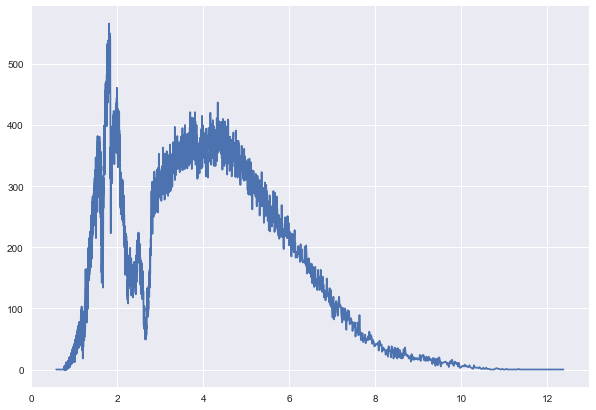

In [6]:
plt.figure(figsize=(10,7))
plt.plot(bin_mid, counts)

Let's load the ARF from a file:

In [7]:
hdulist = fits.open("fake_heg_p1.pha")

In [8]:
hdulist[1].header["TUNIT3"]

'keV'

In [9]:
exposure = hdulist[1].header["EXPOSURE"]

In [10]:
bin_lo = hdulist[1].data.field("BIN_LO")
bin_hi = hdulist[1].data.field("BIN_HI")
channels = hdulist[1].data.field("CHANNEL")
counts = hdulist[1].data.field("COUNTS")

In [52]:
arf_list = fits.open(datadir+"arfs/aciss_heg-1_cy19.garf")

In [53]:
arf_list[1].header["TUNIT1"]

'keV'

In [56]:
specresp = arf_list[1].data.field("SPECRESP")
energ_lo = arf_list[1].data.field("ENERG_LO")
energ_hi = arf_list[1].data.field("ENERG_HI")
phafrac = arf_list[1].data.field("PHAFRAC")

In [57]:
arf_list[1].columns

ColDefs(
    name = 'ENERG_LO'; format = '1E'; unit = 'keV'
    name = 'ENERG_HI'; format = '1E'; unit = 'keV'
    name = 'SPECRESP'; format = '1E'; unit = 'cm**2'
    name = 'BIN_LO'; format = '1E'; unit = 'angstrom'
    name = 'BIN_HI'; format = '1E'; unit = 'angstrom'
    name = 'FRACEXPO'; format = '1E'
    name = 'PHAFRAC'; format = '1E'
)

Let's also load the rmf:

In [58]:
rmf_list = fits.open(datadir+"rmfs/aciss_heg1_cy19.grmf")
rmf_list[1].header["TUNIT1"]

'keV'

Ok, so all of our files have the same units. This is good, because this is not always the case for Chandra/HETG.

**Note**: We need to fix that in the code!

Let's load the ARF and the RMF from `sherpa`:

In [59]:
arf = d.get_arf()
specresp = arf.specresp

rmf = d.get_rmf()

Now we can make a model spectrum we can play around with! `clarsach` has an implementation of a Powerlaw model that matches the `ISIS` one that created the data:

In [60]:
from clarsach.models.powerlaw import Powerlaw

In [61]:
pl = Powerlaw(norm=1.0, phoindex=2.0)

Now we can produce a model with the same resolution as the HETG:

In [62]:
m = pl.calculate(ener_lo=bin_lo, ener_hi=bin_hi)

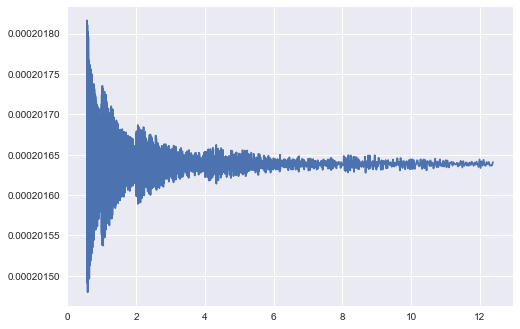

In [63]:
plt.figure()
plt.plot(bin_mid, m)

This looks pretty weird! But remember, those are the integral of the power law over the bins! Let's apply the rmf and arf to this model:

In [64]:
m_arf = m*specresp*1.e5

m_rmf = rmf.apply_rmf(m_arf)

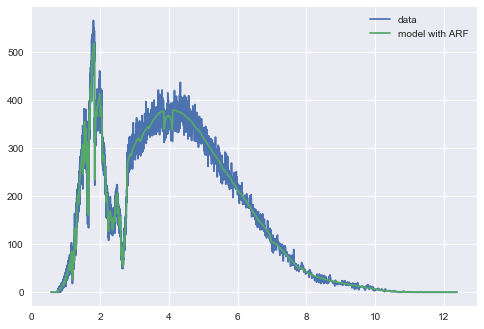

In [65]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_rmf, label="model with ARF")
plt.legend()

Okay, that looks pretty good!

### Building a Model

Let's build a model for fitting a model to the data. We're going to do nothing fancy here, just a simple Poisson likelihood. It's similar to the one in the `TestAthenaXIFU` notebook, except it uses the `Clarsach` powerlaw function and integrates over bins.

In [66]:
class PoissonLikelihood(object):
    
    def __init__(self, x_low, x_high, y, model, arf=None, rmf=None):
        self.x_low = x_low
        self.x_high = x_high
        self.y = y
        self.model = model
        self.arf = arf
        self.rmf = rmf

    def evaluate(self, pars):
        # store the new parameters in the model

        self.model.norm = pars[0]
        self.model.phoindex = pars[1]
        
        # evaluate the model at the positions x
        mean_model = self.model.calculate(self.x_low, self.x_high)

        # run the ARF and RMF calculations
        if arf is not None and rmf is not None:
            m_arf = arf.apply_arf(mean_model)*arf.exposure
            ymodel = rmf.apply_rmf(m_arf)
        else:
            ymodel = mean_model
                
        ymodel += 1e-20
        # compute the log-likelihood
        loglike = np.sum(-ymodel + self.y*np.log(ymodel) \
               - scipy_gammaln(self.y + 1.))

        if np.isfinite(loglike):
            return loglike
        else:
            return -1.e16

    def __call__(self, pars):
        l = -self.evaluate(pars)
        #print(l)
        return l



In [67]:
loglike = PoissonLikelihood(bin_lo, bin_hi, counts, pl, arf=arf, rmf=rmf)
loglike([1.0, 2.0])

1398751.3472584561

Let's fit that:

In [68]:
from scipy.optimize import minimize

In [69]:
opt = minimize(loglike, [1.0, 2.0])

In [70]:
opt

      fun: 21421.497920481364
 hess_inv: array([[  3.93325864e-03,   3.99093102e-04],
       [  3.99093102e-04,   4.07296844e-05]])
      jac: array([-0.00097656,  0.00463867])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 187
      nit: 19
     njev: 44
   status: 2
  success: False
        x: array([ 10.1011883,   1.9971106])

In [71]:
m_fit = pl.calculate(bin_lo, bin_hi)
m_fit_arf = arf.apply_arf(m_fit) * arf.exposure
m_fit_rmf = rmf.apply_rmf(m_fit_arf)

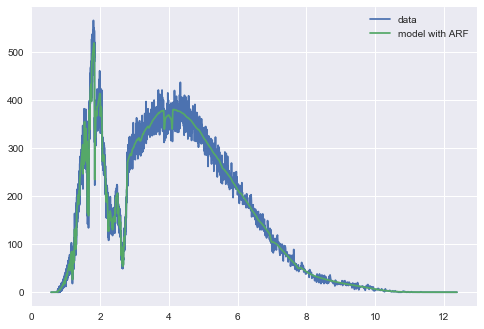

In [72]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_fit_rmf, label="model with ARF")
plt.legend()

Woo! It works! There's something funny with the exposure I need to ask Lia about!

## Making Our Own ARF/RMF Classes

Ideally, we don't want to be dependent on the `sherpa` implementation.
We're now going to write our own implementations, and then test them on the model above.

Let's first write a function for applying the ARF. This is easy, because the ARF just requires a multiplication with the input spectrum.

In [73]:
def apply_arf(spec, specresp):
    """
    Apply the anxilliary response to 
    a spectrum. 
    
    Parameters
    ----------
    spec : numpy.ndarray
        The source spectrum in flux units
        
    specresp: numpy.ndarray
        The response 
        
    exposure : float
        The exposure of the observation
        
    Returns
    -------
    spec_arf : numpy.ndarray
        The spectrum with the response applied.
    
    """
    spec_arf = spec*specresp*exposure
    return spec_arf

Let's try it!

In [74]:
m_arf = apply_arf(m, arf.specresp)

We can compare that with the result from `sherpa`:

In [75]:
m_arf_sherpa = arf.apply_arf(m)

In [76]:
np.allclose(m_arf, m_arf_sherpa)

False

It works! There's also a version in the new `clarsach` package, which we should test and compare as well:

In [77]:
from clarsach.respond import ARF

In [78]:
arf_c = ARF(datadir+"arfs/aciss_heg1_cy19.garf")
m_arf_c = arf_c.apply_arf(m)

In [79]:
np.allclose(m_arf_sherpa, m_arf_c)

True

It works!

Next, let's look at the RMF, which is more complex. This requires a matrix multiplication. However, the response matrices are compressed to remove zeros and save space in memory, so they require a little more complex fiddling. Here's an implementation that is basically almost a line-by-line translation of the C++ code:

In [80]:
def rmf_fold(spec, rmf):
    
    #current_num_groups = 0
    #current_num_chans = 0
    
    nchannels = spec.shape[0]
    
    resp_idx = 0
    first_chan_idx = 0
    num_chans_idx =0
    counts_idx = 0
    
    counts = np.zeros(nchannels)
    
    for i in range(nchannels):
        source_bin_i = spec[i]
        current_num_groups = rmf.n_grp[i]
        
        while current_num_groups:
            counts_idx = int(rmf.f_chan[first_chan_idx] - rmf.offset)
            current_num_chans = rmf.n_chan[num_chans_idx]
            
            first_chan_idx += 1
            num_chans_idx +=1 
            
            while current_num_chans:
                counts[counts_idx] += rmf.matrix[resp_idx] * source_bin_i
                counts_idx += 1
                resp_idx += 1
                current_num_chans -= 1
            
            current_num_groups -= 1
            
    return counts



Let's see if we can make this more vectorized:

In [81]:
def rmf_fold_vector(spec, rmf):
    """
    Fold the spectrum through the redistribution matrix.
    
    Parameters
    ----------
    spec : numpy.ndarray
        The (model) spectrum to be folded
        
    rmf : sherpa.RMFData object
        The object with the RMF data
    
    """    
    # get the number of channels in the data
    nchannels = spec.shape[0]
    
    # an empty array for the output counts
    counts = np.zeros(nchannels)
    
    # index for n_chan and f_chan incrementation
    k = 0
    
    # index for the response matrix incrementation
    resp_idx = 0

    # loop over all channels
    for i in range(nchannels):
        
        # this is the current bin in the flux spectrum to 
        # be folded
        source_bin_i = spec[i]
        
        # get the current number of groups 
        current_num_groups = rmf.n_grp[i]
        
        for j in range(current_num_groups):
            counts_idx = int(rmf.f_chan[k] - rmf.offset)
            current_num_chans = int(rmf.n_chan[k])
            
            k += 1
            
            counts[counts_idx:counts_idx+current_num_chans] += rmf.matrix[resp_idx:resp_idx+current_num_chans] * source_bin_i
            resp_idx += current_num_chans
            
    return counts


Let's time the different implementations and compare them to the `sherpa` version (which is basically a wrapper around the C++):

In [82]:
# not vectorized version
m_rmf = rmf_fold(m_arf, rmf)
%timeit m_rmf = rmf_fold(m_arf, rmf)

1 loop, best of 3: 746 ms per loop


In [83]:
# vectorized version
m_rmf_v = rmf_fold_vector(m_arf, rmf)
%timeit m_rmf_v = rmf_fold_vector(m_arf, rmf)

10 loops, best of 3: 32.5 ms per loop


In [84]:
# C++ (sherpa) version
m_rmf2 = rmf.apply_rmf(m_arf)
%timeit m_rmf2 = rmf.apply_rmf(m_arf)

1000 loops, best of 3: 746 µs per loop


So my vectorized implementation is ~20 times slower than the sherpa version, and the non-vectorized version is *really* slow. But are they all the same?

In [85]:
np.allclose(m_rmf_v, m_rmf2)

True

In [86]:
np.allclose(m_rmf, m_rmf2)

True

They are! It looks like for this particular Chandra/HETG data set, it's working! 

## Making an ARF/RMF Class

the ARF and RMF code would live well in a class, so let's wrap it into a class:

In [87]:
class RMF(object):
    
    def __init__(self, filename):
        
        self._load_rmf(filename)
        pass
    
    def _load_rmf(self, filename):
        """
        Load an RMF from a FITS file.
        
        Parameters
        ----------
        filename : str
            The file name with the RMF file
            
        Attributes
        ----------
        n_grp : numpy.ndarray
            the Array with the number of channels in each 
            channel set
        
        f_chan : numpy.ndarray
            The starting channel for each channel group;
            If an element i in n_grp > 1, then the resulting 
            row entry in f_chan will be a list of length n_grp[i];
            otherwise it will be a single number
            
        n_chan : numpy.ndarray
            The number of channels in each channel group. The same 
            logic as for f_chan applies
            
        matrix : numpy.ndarray
            The redistribution matrix as a flattened 1D vector
            
        energ_lo : numpy.ndarray
            The lower edges of the energy bins
        
        energ_hi : numpy.ndarray
            The upper edges of the energy bins
            
        detchans : int
            The number of channels in the detector
        
        """
        # open the FITS file and extract the MATRIX extension
        # which contains the redistribution matrix and 
        # anxillary information
        hdulist = fits.open(filename)
        h = hdulist["MATRIX"]
        data = h.data
        hdr = h.header
        hdulist.close()
        
        # extract + store the attributes described in the docstring 
        n_grp = np.array(data.field("N_GRP"))
        f_chan = np.array(data.field('F_CHAN'))
        n_chan = np.array(data.field("N_CHAN"))
        matrix = np.array(data.field("MATRIX"))
        self.energ_lo = np.array(data.field("ENERG_LO"))
        self.energ_hi = np.array(data.field("ENERG_HI"))
        self.detchans = hdr["DETCHANS"]
        self.offset = 1#  self.__get_tlmin(h)
        
        self.n_grp, self.f_chan, self.n_chan, self.matrix = \
                self.__flatten_arrays(n_grp, f_chan, n_chan, matrix)
        
        return
    
    def __get_tlmin(self, h):
        """
        Get the tlmin keyword for `F_CHAN`.
        
        Parameters
        ----------
        h : an astropy.io.fits.hdu.table.BinTableHDU object
            The extension containing the `F_CHAN` column
            
        Returns
        -------
        tlmin : int
            The tlmin keyword
        """
        # get the header
        hdr = h.header
        # get the keys of all 
        keys = np.array(list(hdr.keys()))
        
        # find the place where the tlmin keyword is defined
        t = np.array(["TLMIN" in k for k in keys])
        
        # get the index of the TLMIN keyword
        tlmin_idx = np.hstack(np.where(t))[0]
        
        # get the corresponding value
        tlmin = np.int(list(hdr.items())[tlmin_idx][1])
        
        return tlmin
        
    def __flatten_arrays(self, n_grp, f_chan, n_chan, matrix):
        
        # find all non-zero groups
        nz_idx = (n_grp > 0)
        
        # stack all non-zero rows in the matrix
        matrix_flat = np.hstack(matrix[nz_idx])
        
        # stack all nonzero rows in n_chan and f_chan
        n_chan_flat = np.hstack(n_chan[nz_idx])
        f_chan_flat = np.hstack(f_chan[nz_idx])
        
        return n_grp, f_chan_flat, n_chan_flat, matrix_flat
            
    def apply_rmf(self, spec):
        """
        Fold the spectrum through the redistribution matrix.

        The redistribution matrix is saved as a flattened 1-dimensional 
        vector to save space. In reality, for each entry in the flux 
        vector, there exists one or more sets of channels that this 
        flux is redistributed into. The additional arrays `n_grp`, 
        `f_chan` and `n_chan` store this information:
            * `n_group` stores the number of channel groups for each 
              energy bin
            * `f_chan` stores the *first channel* that each channel 
              for each channel set 
            * `n_chan` stores the number of channels in each channel 
              set 
              
        As a result, for a given energy bin i, we need to look up the 
        number of channel sets in `n_grp` for that energy bin. We 
        then need to loop over the number of channel sets. For each 
        channel set, we look up the first channel into which flux 
        will be distributed as well as the number of channels in the 
        group. We then need to also loop over the these channels and 
        actually use the corresponding elements in the redistribution 
        matrix to redistribute the photon flux into channels. 
        
        All of this is basically a big bookkeeping exercise in making 
        sure to get the indices right.
        
        Parameters
        ----------
        spec : numpy.ndarray
            The (model) spectrum to be folded

        Returns
        -------
        counts : numpy.ndarray
            The (model) spectrum after folding, in 
            counts/s/channel

        """    
        # get the number of channels in the data
        nchannels = spec.shape[0]

        # an empty array for the output counts
        counts = np.zeros(nchannels)

        # index for n_chan and f_chan incrementation
        k = 0

        # index for the response matrix incrementation
        resp_idx = 0

        # loop over all channels
        for i in range(nchannels):

            # this is the current bin in the flux spectrum to 
            # be folded
            source_bin_i = spec[i]

            # get the current number of groups 
            current_num_groups = self.n_grp[i]

            # loop over the current number of groups
            for j in range(current_num_groups):
                
                # get the right index for the start of the counts array 
                # to put the data into
                counts_idx = int(self.f_chan[k] - self.offset)
                
                # this is the current number of channels to use
                current_num_chans = int(self.n_chan[k])

                # iterate k for next round
                k += 1
                
                # add the flux to the subarray of the counts array that starts with 
                # counts_idx and runs over current_num_chans channels
                counts[counts_idx:counts_idx+current_num_chans] = counts[counts_idx:counts_idx+current_num_chans] + \
                                                                  self.matrix[resp_idx:resp_idx+current_num_chans] * \
                                                                  np.float(source_bin_i)
                # iterate the response index for next round
                resp_idx += current_num_chans

        return counts
    

Let's make an object of that class and then make another model with the RMF applied:

In [88]:
rmf_new = RMF(datadir+"rmfs/aciss_heg1_cy19.grmf")
m_rmf = rmf_new.apply_rmf(m_arf)

Does this produce the same result as the vectorized function (it should)?

In [89]:
np.allclose(m_rmf, m_rmf_v)

True

Hooray! What does the total spectrum look like?

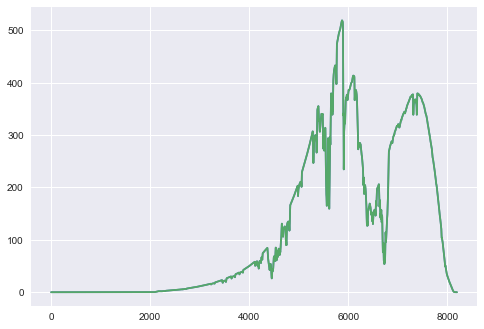

In [90]:
plt.figure()
plt.plot(m_rmf)
plt.plot(m_rmf_v)

There is, of course, also an implementation in `clarsach`:

In [91]:
from clarsach import respond

In [92]:
rmf_c = respond.RMF(datadir+"rmfs/aciss_heg1_cy19.grmf")

In [93]:
m_rmf_c = rmf_new.apply_rmf(m_arf)

In [94]:
np.allclose(m_rmf_c, m_rmf_v)

True

It all works! Hooray! I think we've got a solution for Chandra/HETG!

Let's make a final plot:

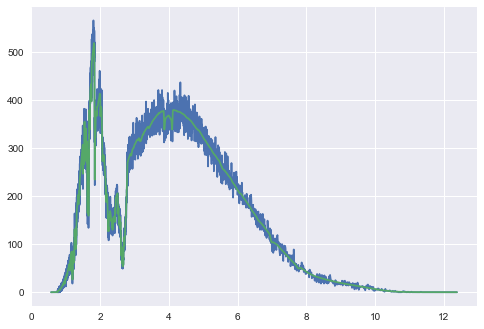

In [95]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_rmf_c, label="model")

It all works! Woo!